In [371]:
import pystan
import bebi103
import numpy as np
import bokeh
import matplotlib.pyplot as plt

%matplotlib notebook

In [270]:
import scipy.stats as sts

In [284]:
prior_predictive_model_code_1 = """
data {
  int N;
  real phi_mu;
  real phi_sigma;
  real sigma_0_alpha;
  real sigma_0_beta;
}


generated quantities {
  // Parameters
  real<lower=0> phi;
  real<lower=0> sigma_0;
  real<lower=0> sigma;
  real myvar;

  // Data
  real ell[N];
  
  myvar = normal_rng(phi_mu, phi_sigma);
  phi = lognormal_rng(phi_mu, phi_sigma);
  sigma_0 = gamma_rng(sigma_0_alpha, sigma_0_beta);
  sigma = sigma_0 * phi;

  for (i in 1:N) {
    ell[i] = normal_rng(phi, sigma);
  }
}
"""

behavior_predictive_model_code = """
data {
   int N;
   real sigma1;
   real sigma2;
   real sigma3;
   real sigma4;
}

generated quantities {
   // Parameters
   real w1[N];
   real w2[N];
   real w3[N];
   real w4[N];
   
   real n1[N];
   real n2[N];
   real n3[N];
   real n4[N];
   
   real g1[N];
   real g2[N];
   real g3[N];
   real g4[N];
   real total[N];
   real prob[N];
   
   // Data
   int y[N];
   
   // Initialize w's
   w1[1] = normal_rng(0, 1);
   w2[1] = normal_rng(0, 1);
   w3[1] = normal_rng(0, 1);
   w4[1] = normal_rng(0, 1);
   
   for (i in 1:N){
       // Sample g's from standard normal
       g1[i] = normal_rng(0, 1);
       g2[i] = normal_rng(0, 1);
       g3[i] = normal_rng(0, 1);
       g4[i] = normal_rng(0, 1);
       
       // Sample w's: Gaussian random walk
       n1[i] = normal_rng(0, sigma1);
       n2[i] = normal_rng(0, sigma2);
       n3[i] = normal_rng(0, sigma3);
       n4[i] = normal_rng(0, sigma4);
       
       if (i > 1) {
           w1[i] = w1[i - 1] + n1[i];
           w2[i] = w2[i - 1] + n2[i];
           w3[i] = w3[i - 1] + n3[i];
           w4[i] = w4[i - 1] + n4[i];
           
           //Reflect off boundary
           //w1[i] = min(w1[i], 4.0)
       }
       
       // Compute total
       total[i] = g1[i]*w1[i] + g2[i]*w2[i] + g3[i]*w3[i] + g4[i]*w4[i]; 
       
       // Transform to probability
       prob[i] = 1/(1 + exp(-total[i]));
       
       y[i] = bernoulli_rng(prob[i]);
   }
}
"""



In [318]:
# Fake data for inference model
N = 100
sigma1 = 1/32
sigma2 = 1/64
sigma3 = 1/128
sigma4 = 1/64

n1 = np.random.normal(0, sigma1, size=N)
n2 = np.random.normal(0, sigma2, size=N)
n3 = np.random.normal(0, sigma3, size=N)
n4 = np.random.normal(0, sigma4, size=N)

w1 = np.cumsum(n1) + np.random.normal(0, 1)
w2 = np.cumsum(n2) + np.random.normal(0, 1)
w3 = np.cumsum(n3) + np.random.normal(0, 1) 
w4 = np.cumsum(n4) + np.random.normal(0, 1)

g1 = np.random.normal(0, sigma1, size=N)
g2 = np.random.normal(0, sigma2, size=N)
g3 = np.random.normal(0, sigma3, size=N)
g4 = np.random.normal(0, sigma4, size=N)

total = g1 * w1 + g2 * w2 + g3 * w3 + g4 * w4
prob = 1/(1 + np.exp(-total))
samples = np.random.rand(len(prob))
yvals = (samples > prob).astype('int')

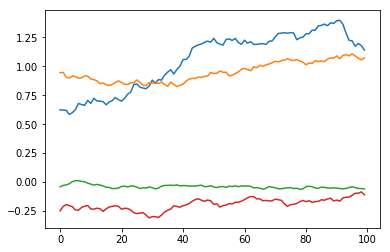

In [319]:
plt.plot(w1)
plt.plot(w2)
plt.plot(w3)
plt.plot(w4)

In [328]:
behavior_inference_model_code = """
data {
  int N;
  int n[N];
  vector[N] g1;
  vector[N] g2;
  vector[N] g3;
  vector[N] g4;
}


parameters {
  vector[N] n1;
  vector[N] n2;
  vector[N] n3;
  vector[N] n4;
}


transformed parameters {
  vector[N] w1;
  vector[N] w2;
  vector[N] w3;
  vector[N] w4;
  vector[N] evidence;
  vector[N] prob;
  
  w1[1] = n1[1];
  w2[1] = n2[1];
  w3[1] = n3[1];
  w4[1] = n4[1];
  
  for (i in 2:N) {
    w1[i] = w1[i - 1] + n1[i];
    w2[i] = w2[i - 1] + w2[i];
    w3[i] = w3[i - 1] + n3[i];
    w4[i] = w4[i - 1] + w4[i];
    evidence[i] = g1[i] * w1[i] + g2[i] * w2[i] + g3[i] * w3[i] + g4[i] * w4[i];
    prob[i] = 1.0 ./ (1 + exp(-evidence[i]));
  }
}

model {
  // Priors
  n1 ~ normal(0, 1);
  n2 ~ normal(0, 1);
  n3 ~ normal(0, 1);
  n4 ~ normal(0, 1);
    
  // Likelihood
  n ~ bernoulli(prob);
}
"""

beh_inf = pystan.StanModel(model_code=behavior_inference_model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6b1c852c357ae3dbdb9f61f8aa2b497f NOW.


In [330]:
behavior_inference_model_code2 = """
data {
  int N;
  int n[N];
  vector[N] g1;
  vector[N] g2;
  vector[N] g3;
  vector[N] g4;
}


parameters {
  vector[N] n1;
  vector[N] n2;
  vector[N] n3;
  vector[N] n4;
}


transformed parameters {
  vector[N] w1;
  vector[N] w2;
  vector[N] w3;
  vector[N] w4;
  vector[N] evidence;
  vector[N] prob;
  
  w1[1] = n1[1];
  w2[1] = n2[1];
  w3[1] = n3[1];
  w4[1] = n4[1];
  
  for (i in 2:N) {
    w1[i] = w1[i - 1] + n1[i];
    w2[i] = w2[i - 1] + w2[i];
    w3[i] = w3[i - 1] + n3[i];
    w4[i] = w4[i - 1] + w4[i];
  }
  
  evidence = g1 .* w1 + g2 .* w2 + g3 .* w3 + g4 .* w4;
  prob = 1.0 ./ (1 + exp(-evidence));
}

model {
  // Priors
  n1 ~ normal(0, 1);
  n2 ~ normal(0, 1);
  n3 ~ normal(0, 1);
  n4 ~ normal(0, 1);
    
  // Likelihood
  n ~ bernoulli(prob);
}
"""

beh_inf = pystan.StanModel(model_code=behavior_inference_model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6b1c852c357ae3dbdb9f61f8aa2b497f NOW.


In [481]:
behavior_inference_model_code = """
data {
  int N;
  int y[N];
  vector[N] g1;
}


parameters {
  vector[N] n1;
}


transformed parameters {
  vector[N] w1;
  vector[N] evidence;
  vector[N] prob;
  
  w1[1] = n1[1];
  
  for (i in 2:N) {
    w1[i] = w1[i - 1] + n1[i];
  }
  
  evidence = g1 .* w1;
  prob = 1.0 ./ (1 + exp(-evidence));
}

model {
  // Priors
  n1 ~ normal(0, 1);
 
  // Likelihood
  y ~ bernoulli(prob);
}
"""

beh_inf = pystan.StanModel(model_code=behavior_inference_model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_eac3af7604fbadbd333d2bb6ef8334fa NOW.


In [489]:
np.random.normal(0, 1)

-1.3267636477996068

In [503]:
w1 = np.zeros(N)
w1[0] = np.random.normal(0, 1)
for i in range(1, N):
    w1[i] = np.random.normal(w1[i-1], 1)

<IPython.core.display.Javascript object>


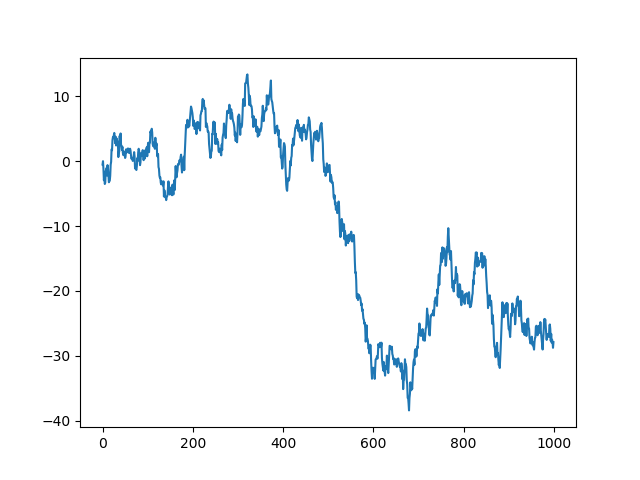

In [504]:
plt.figure()
plt.plot(w1)

In [501]:
# Fake data for simple inference
N = 1000
sigma1 = 1

n1 = np.random.normal(0, sigma1, size=N)
w1 = np.zeros(len(n1))

for i, nval in enumerate(n1):
    if i == 0:
        w1[i] = n1[i]
    else:
        w1[i] = w1[i-1] + n1[i]
        
    # Enforce boundary
    #if w1[i] > 4:
     #   w1[i] = 4
    #if w1[i] < -4:
     #   w1[i] = -4


g1 = np.random.normal(0, sigma1, size=N)

total = g1 * w1
prob = 1.0/(1.0 + np.exp(-total))
samples = np.random.rand(len(prob))
yvals = (samples < prob).astype('int')

<IPython.core.display.Javascript object>


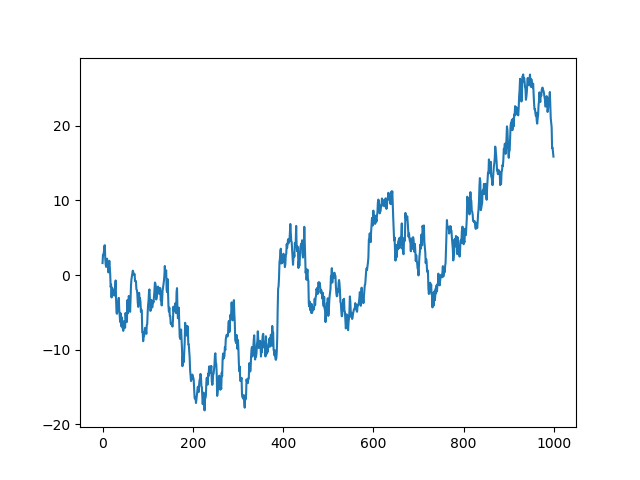

In [502]:
plt.figure()
plt.plot(w1)

In [487]:
data_inf = dict(N=1000,
               y=yvals.astype('int'),
               g1=g1)

samples_beh_inf = beh_inf.sampling(data=data_inf, warmup=1000, iter=2000)

<IPython.core.display.Javascript object>


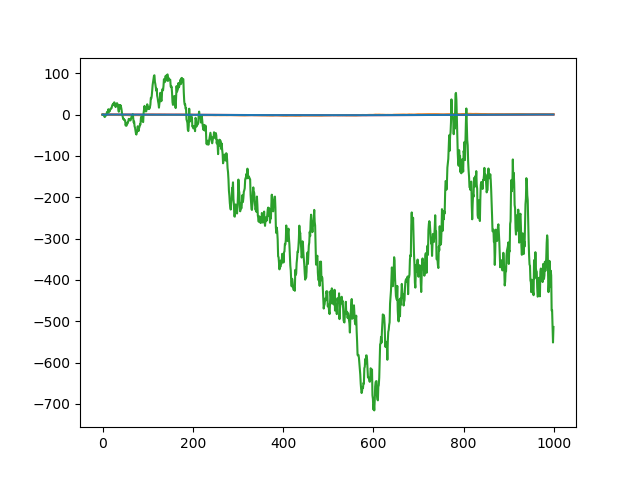

In [488]:
# Get samples of w1 and plot
n1samp = samples_beh_inf['w1']
means = np.mean(n1samp, axis=0)
std = np.std(n1samp, axis=0)
plt.figure(5)

plt.errorbar(np.arange(1000), means, std)
plt.plot(means, 'r')
plt.plot(w1)

In [386]:
n1samp[:,0]

array([-0.56679574,  0.2220973 ,  0.33346784, ..., -0.89866851,
       -0.72202503,  0.2989821 ])

<IPython.core.display.Javascript object>


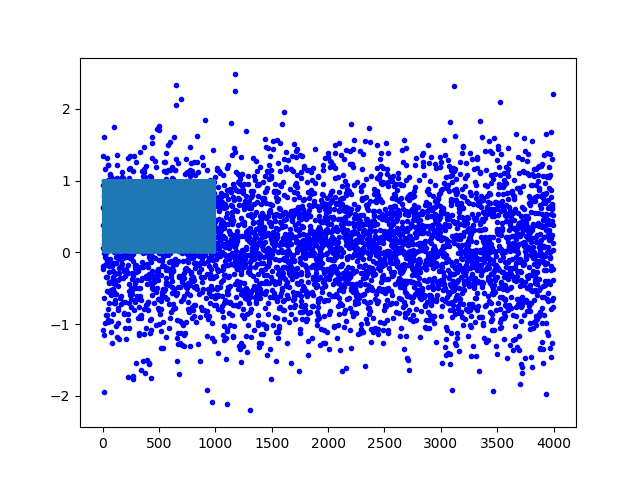

In [456]:
n1samp = samples_beh_inf['w1']
plt.figure()
plt.plot(n1samp[:,500], 'b.');
plt.show()

In [383]:
samples_beh_inf


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_c90ff2ba531e6342aa50877294ed32d7.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
n1[1]   -0.25    0.01   0.77  -1.81  -0.77  -0.25   0.25   1.26   4126    1.0
n1[2]    0.22    0.01   0.85  -1.44  -0.36   0.23    0.8   1.88   3729    1.0
n1[3]    -0.1    0.01   0.88  -1.84  -0.69   -0.1    0.5   1.63   4569    1.0
n1[4]    0.55    0.01   0.86  -1.12  -0.04   0.56   1.13    2.3   4446    1.0
n1[5]   -0.07    0.01    0.9  -1.85  -0.67  -0.06   0.53   1.69   5433    1.0
n1[6]   -0.23    0.01    0.9   -2.0  -0.82  -0.22   0.35   1.51   4720    1.0
n1[7]   -0.66    0.01   0.88  -2.37  -1.24  -0.65  -0.07   1.11   4316    1.0
n1[8]   -0.35    0.01   0.89  -2.13  -0.93  -0.34   0.25    1.4   5146    1.0
n1[9]    0.17    0.01   0.89  -1.59  -0.41   0.18   0.77   1.93   476

In [405]:
# Generate fake data
N = 100
sigma1 = 3.0
n1 = np.random.normal(0, sigma1, size=N)
prob = 1.0 / (1 + np.exp(-n1))
samples = np.random.rand(len(prob))
yvals = (samples < prob).astype('int')

In [235]:
behavior_simple_model_code = """
data {
  int N;
  int y[N];
}


parameters {
  real sigma1;
  vector[N] n1;
}

transformed parameters {
  vector[N] prob = 1.0 ./ (1 + exp(-n1));
}

model {
  // Priors
  sigma1 ~ lognormal(0, 10);
  n1 ~ normal(0, sigma1);
  
  // Likelihood
  y ~ bernoulli(prob);
}
"""
beh_inf_simple = pystan.StanModel(model_code=behavior_simple_model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ccd799ebcaa3f7d8a19df9fd5701a815 NOW.


In [260]:
data_inf_simple = dict(N=100,
               y=yvals.astype('int'))

samples_beh = beh_inf_simple.sampling(data=data_inf_simple, warmup=10000, iter=20000)

In [261]:
samples_beh


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_ccd799ebcaa3f7d8a19df9fd5701a815.
4 chains, each with iter=20000; warmup=10000; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=40000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma1  75.78    9.42  77.61   5.92  17.16  45.49 106.24 287.24     68   1.01
n1[1]  -59.93    7.45  87.51 -328.0 -73.18 -25.52  -8.53   -0.1    138   1.01
n1[2]  -60.28     7.6  88.71 -326.4 -73.11 -25.35   -8.4   -0.2    136   1.01
n1[3]   -59.9    7.25  88.73 -324.7 -72.24  -25.4  -8.44  -0.04    150    1.0
n1[4]  -59.94    7.23  87.11 -323.8 -72.55 -25.59  -8.54   -0.2    145   1.01
n1[5]    60.6    7.61  87.94   0.01   8.41  25.95  74.54  330.0    133   1.01
n1[6]  -60.69    7.61  89.39 -334.4 -73.03 -25.53  -8.56  -0.08    138   1.01
n1[7]   62.32    8.09  95.98   0.18   8.84  25.58  73.89 347.47    141   1.01
n1[8]  -60.42    7.53  88.57 -333.8  -73.0 -25.32  -8.51   -0.1  

In [276]:
np.linspace(0,100,100)

array([  0.        ,   1.01010101,   2.02020202,   3.03030303,
         4.04040404,   5.05050505,   6.06060606,   7.07070707,
         8.08080808,   9.09090909,  10.1010101 ,  11.11111111,
        12.12121212,  13.13131313,  14.14141414,  15.15151515,
        16.16161616,  17.17171717,  18.18181818,  19.19191919,
        20.2020202 ,  21.21212121,  22.22222222,  23.23232323,
        24.24242424,  25.25252525,  26.26262626,  27.27272727,
        28.28282828,  29.29292929,  30.3030303 ,  31.31313131,
        32.32323232,  33.33333333,  34.34343434,  35.35353535,
        36.36363636,  37.37373737,  38.38383838,  39.39393939,
        40.4040404 ,  41.41414141,  42.42424242,  43.43434343,
        44.44444444,  45.45454545,  46.46464646,  47.47474747,
        48.48484848,  49.49494949,  50.50505051,  51.51515152,
        52.52525253,  53.53535354,  54.54545455,  55.55555556,
        56.56565657,  57.57575758,  58.58585859,  59.5959596 ,
        60.60606061,  61.61616162,  62.62626263,  63.63

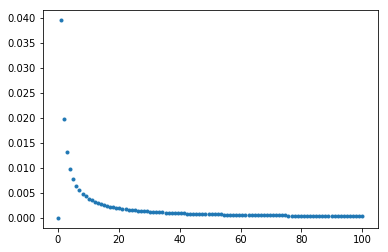

In [283]:
a = sts.lognorm.pdf(np.linspace(0,100, 100), loc=0, s=10)
plt.plot(np.linspace(0,100,100), a, '.')

In [258]:
samples_beh['sigma1'].shape

(32000,)

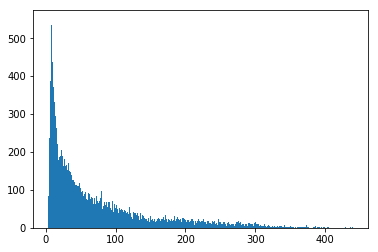

In [267]:
plt.hist(samples_beh['sigma1'], bins=1000);

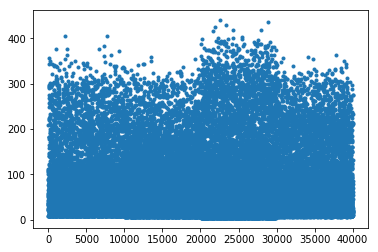

In [262]:
plt.plot(samples_beh['sigma1'], '.')

(array([1068.,  371.,  146.,   68.,   71.,   91.,  102.,   44.,   27.,
          12.]),
 array([1.40690923e-01, 2.84572941e+01, 5.67738973e+01, 8.50905005e+01,
        1.13407104e+02, 1.41723707e+02, 1.70040310e+02, 1.98356913e+02,
        2.26673517e+02, 2.54990120e+02, 2.83306723e+02]),
 <a list of 10 Patch objects>)

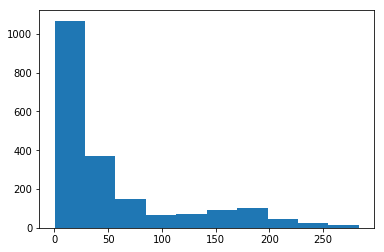

In [243]:
sig1vals = samples_beh['sigma1']
plt.hist(sig1vals)

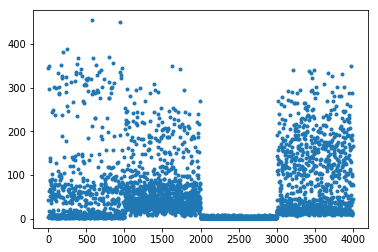

In [239]:
plt.plot(samples_beh['sigma1'], '.')

In [173]:
#sm_gen = bebi103.stan.StanModel(model_code=prior_predictive_model_code_1)
#beh_gen = bebi103.stan.StanModel(model_code=behavior_predictive_model_code)
beh_gen = pystan.StanModel(model_code=behavior_inference_model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_630de16260f6398c402192b129cbb2c6 NOW.


In [136]:
beh_data = pystan.StanModel(model_code=behavior_predictive_model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5c2305c349b1a93ba91f30545c86c6a0 NOW.


In [ ]:
beh_simple = pystan.StanModel(model_code=behavior_simple_model_code)
# Sample and perform inference
data_simple = dict(N=1000,
               g1=g1val,
               n=yval)

In [179]:
samples_inf = beh_simple.sampling(data=data_simple,
                              warmup=0,
                              chains=1,
                              iter=2)

C:\Anaconda3\lib\site-packages\pystan\misc.py:356: RuntimeWarning: invalid value encountered in sqrt
  sem=msd[:, 1] / np.sqrt(ess), ess=ess, rhat=rhat,


In [137]:
data_beh = dict(N=1000,
               sigma1=1/32,
               sigma2=1/64,
               sigma3=1/128,
               sigma4=1/64)

samples_beh = beh_data.sampling(data=data_beh,
                              algorithm='Fixed_param',
                              warmup=0,
                              chains=1,
                              iter=20)

In [169]:
# Extract the g values in the simulation
g1val = samples_beh['g1'][0,:]
g2val = samples_beh['g2'][0,:]
g3val = samples_beh['g3'][0,:]
g4val = samples_beh['g4'][0,:]
yval = samples_beh['y'][0,:]

In [170]:
yval = yval.astype('int')

In [171]:
# Sample and perform inference
data_inf = dict(N=1000,
               g1=g1val,
               g2=g2val,
               g3=g3val,
               g4=g4val,
               n=yval)
samples_inf = beh_gen.sampling(data=data_inf,
                              warmup=0,
                              chains=1,
                              iter=2)

RuntimeError: Initialization failed.

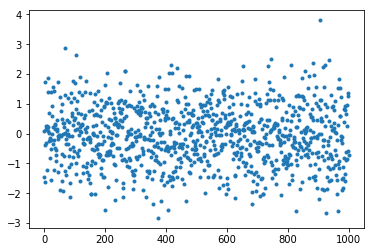

In [147]:
plt.plot(g1val, '.')

In [4]:
data = dict(N=1000,
            phi_mu=np.log(20),
            phi_sigma=0.75,
            sigma_0_alpha=2.0,
            sigma_0_beta=10)

In [15]:
w1arr = samples_beh['w1']
w2arr = samples_beh['w2']
w3arr = samples_beh['w3']
w4arr = samples_beh['w4']

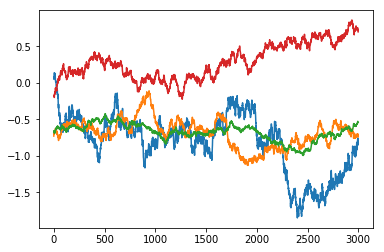

In [7]:
plt.plot(w1arr[0,:].T)
plt.plot(w2arr[0,:].T)
plt.plot(w3arr[0,:].T)
plt.plot(w4arr[0,:].T)

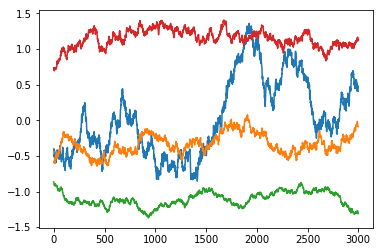

In [16]:
plt.plot(w1arr[0,:].T)
plt.plot(w2arr[0,:].T)
plt.plot(w3arr[0,:].T)
plt.plot(w4arr[0,:].T)